# 贝叶斯分析确定理论模型参数

庞龙刚@华中师范大学

## 内容

- 贝叶斯定理
- 使用 MCMC 抽样后验分布 (Posterior)
- 贝叶斯分析确定理论模型参数
- 加速方案
- 总结

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm
import os

plt.style.use(['science', 'notebook', 'no-latex'])

### 什么是科学的研究方法?

    First you guess. Don't laugh, this is the most important step. 
    Then you compute the consequences. 
    Compare the consequences to experience. 
    If it disagrees with experience, the guess is wrong. 
    In that simple statement is the key to science. 
    It doesn't matter how beautiful your guess is or 
    how smart you are or what your name is.
    If it disagrees with experience, it's wrong.
    That's all there is to it.         
                                  --By Richard P. Feynman

翻译过来就是几个步骤
1. “你先猜，建个模“
2. “用这个模型算个结果“
3. “拿这个结果跟实验数据对比“
4. “符合实验就是对的。不符合就是错的。“

科研中大家经常会莫名其妙的变成调参侠 -- 因为我们需要先“建个模”



\begin{align}
y_{pred} = M(x, \theta)
\end{align}

- $y_{\rm pred}$ 是模型输出，
- $M(\cdot)$ 是我们的物理模型， 
- $x$ 是给定的输入
- $\theta$ 是模型参数。

### 使用模型 $y_{pred} = M(x, \theta)$ 拟合实验数据 $y$ 等价于

1. 寻找 $\theta$ 以减小数据与模型预测的距离 ${\rm \bf d(y, y_{pred})}$
2. 告诉大家 $\theta$ 的置信度（或者称模型的不确定度）

那个距离可以理解为“似然”程度，距离越小，似然越大。

寻找使得模型预言与实验数据距离 $d(y, y_{pred})$ 最小的那组参数 $\theta$，称作最大似然估计 MLE。

### 回忆贝叶斯公式

\begin{align}
P(\theta | y)  = \frac{ P(y | \theta)P(\theta) }{P(y)}
\end{align}

分母可以展开，
\begin{align}
P(y) &= \int  P(y, \theta) d\theta \\
     &= \int  P(y | \theta) P(\theta)d\theta \\
     & \approx \sum_i P(y | \theta_i) P(\theta_i)
\end{align}

### 贝叶斯分析 （Bayesian analysis）


\begin{align}
P(\theta | y) = \frac{\bf P(y | \theta) P(\theta)}{\sum_i P(y | \theta_i) P(\theta_i)}
\end{align}

- 贝叶斯分析：寻找给定实验数据 $y$ 情况下的模型参数 $\theta$ 的后验概率分布 $P(\theta | y)$
- 最大似然估计 MLE：寻找 $P(y | \theta)$ 取峰值时的 $\theta$
- 最大后验估计 MAP：寻找 $P(\theta | y)$ 取峰值时的 $\theta$

费曼对科研的描述中，

1. “First you guess”对应先验（a prior), 即基于以往的经验，你对参数的估计，或者说你认为 $\theta$ 的取值所应满足的分布 -- $P(\theta)$ 。
2. “Compute the consequences, and compare with experience" 对应似然函数 （likelihood) $P(y | \theta)$ ，即看模型输出与实验数据到底有多相似。
3. 费曼没有提如果有很多模型都可以描述同样的实验数据，那么真实理论是其中一种的几率就会降低。这一项对应归一化系数，即分母上对不同参数的似然加权求和。有时又称“证据” Evidence。
4. 费曼也没有提人们对模型参数的信仰会随着数据的增多而发生改变和更新。这就是后验（Posterior）。

## 关于模型

物理模型都是真实世界的近似描述。 $M(x, \theta)$ 对于不同的参数，张开了一个函数空间，真实世界的函数一般并不在此空间中。但是，只要对某组参数，$M(x, \theta)$ 能够近似描述实验数据，就可以认为它是真实世界的一个有效模型。

很多时候，我们需要跟实验对比，寻找这个有效模型的参数 $\theta$。

举例，模型有两个参数， $\theta = \{ \theta_1, \theta_2 \}$ , 构成 2 维参数空间，可以使用网格搜索法逐点探索。

但对于大部分参数点来说，模型输出与实验数据的似然（ likelihood ）都很低，处于不值得浪费时间探索的参数空间区域，如下图所示

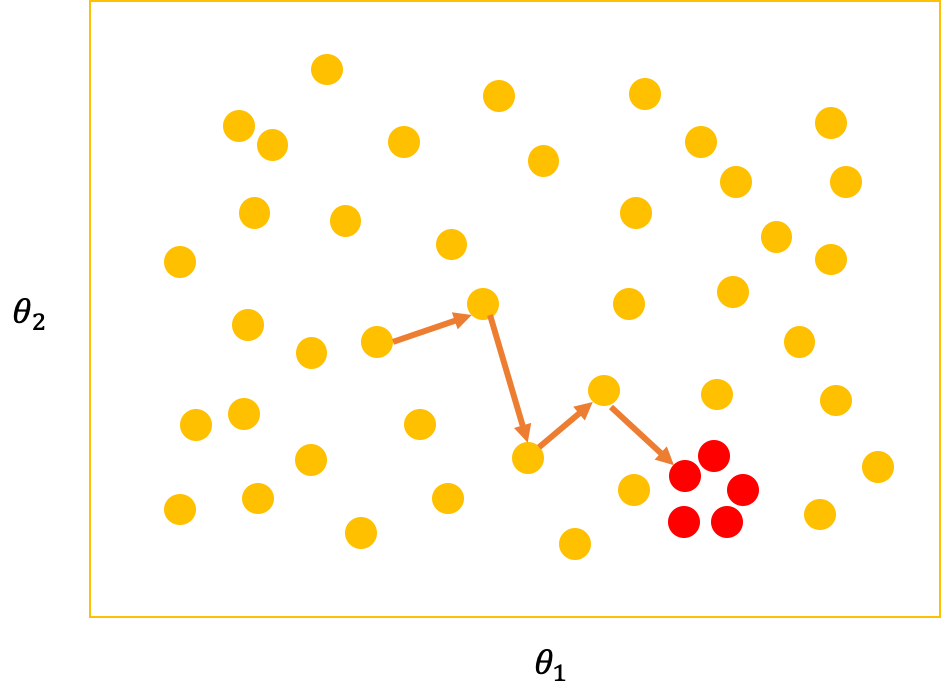

In [152]:
Image("images/bayes_parameter_search.jpg", height=400) 
# 二维参数空间。黄色圆点对应低 likelihood，红色圆点对应高 likelihood 区域，
# 模型可以近似描述实验。贝叶斯分析要从参数空间的某一点出发，通过随机游走，快速找到高 likelihood 区域。
# 如果红色区域很大，则很多参数点都能描述实验，后验分布是某个参数点的机会降低

- 手动调参不易！ 尤其是当模型中有多个参数的时候 (高维参数空间）
- 贝叶斯分析可以帮助我们在高维参数空间行走，快速找到参数的后验分布
- 如果很多参数组合给出相近的结果，则模型的不确定性增大，置信度减小

在贝叶斯公式里，实验数据 y 已知，要计算参数的后验分布会发现分母上 $\sum_i P(y | \theta_i) P(\theta_i)$ 很难计算，它要求遍历整个参数空间，如果是高维参数空间，遍历很难做到。

幸运的是马尔可夫链蒙特卡洛 MCMC 技术可以从非归一化的分布函数抽样，也就是说只需要计算如下非归一化的后验分布，

\begin{align}
 P(\theta | y) \propto P(y | \theta) P(\theta)
\end{align}

从这个非归一化的后验分布抽样，得到满足实验数据的模型参数的分布，是贝叶斯分析最重要的目标。

MCMC 里最简单的实现是 Metropolis-Hastings 算法，这里以一个简单的例子回顾 MH 算法如何工作，

例子：使用 Metropolis-Hastings 算法从一维分布 $f(\theta) = \exp(-|\theta|)$  抽样。

Metropolis-Hastings 算法:
1. 初始化一个空列表  X = [ ], 用来存放所有抽样得到的点；
2. 从参数空间任一点 $\theta_0$ 出发。
3. 根据前一步的位置做随机行走， $\theta_{i+1} = \theta_i + \epsilon$, 其中 $\epsilon$ 是从正态分布或均匀分布抽样得到的步长。
4. 定义舍选率 $\alpha = \min\left\{ {f(\theta_{i+1}) \over f(\theta_i)}, 1\right\}$ , 按均匀分布抽样 $r \sim U(0, 1)$。
   - 如果 $r \le \alpha$, 则将 $\theta_{i+1}$ 放入 X 列表中；
   - 否则，将前一步抽样的 $\theta_{i}$ 放入 X 列表
5. 转到第 2 步

Metropolis-Hastings 算法最终产生一个数组， 
$X = \left[\theta_0, \theta_1, \theta_2,\cdots,\theta_i, \theta_{i+1},\cdots, \theta_n \right]$，
用 histogram 画出参数的分布，会发现它满足 $f(\theta) = \exp(-|\theta|)$，

In [153]:
def mcmc(func, ranges, n=100000, warmup=0.1, thin=1, step=1):
    '''Metropolis-Hastings sampling for distribution func
    :func: non-normalized distribution function (parameters x are ndim np.array)
    :ranges: the lower and upper bound of params, its shape determines ndim,
             np.array([[xmin, xmax], [ymin, ymax], [zmin, zmax], [..., ...]])
    :n: number of samples
    :warmup: ratio of samples that will be discarded 
    :thin: samples to skip in the output
    :step: effective step length in the proposal function'''
    ndim = ranges.shape[0]
    r1 = np.random.randn(n, ndim)           # for random walk
    r2 = np.random.rand(n)                  # for reject or accept
    
    samples = np.empty((n, ndim), dtype=np.float32)
    xmin, xmax = ranges[:, 0], ranges[:, 1]
    # start from somewhere in the parameter space
    r = np.random.rand(ndim)
    x0 = xmin * (1 - r) + xmax * r               # initial sample
    step  = step * (xmax - xmin) / (xmax - xmin).max()
    
    for i in tqdm(range(n)):
        x1 = x0 + r1[i] * step
        alpha = min(func(x1) / func(x0), 1)          # acception rate
        if (r2[i] <= alpha) and (x1>xmin).all()    \
           and (x1<xmax).all():                      # accept the current move
            x0 = x1
            
        samples[i] = x0                              # or keep the previous move
    return samples[int(warmup*n):-1:thin]

In [154]:
# 调用上面实现的 MH 算法，对函数 \exp(-|\theta|) 抽样

def fun(theta):
    return np.exp(-np.abs(theta))

# get 100,000 samples using mcmc
ranges_ = np.array([[-5, 5]])
samples = mcmc(fun, ranges_, n=1000000, warmup=0.1, thin=10)

100%|██████████| 1000000/1000000 [00:08<00:00, 124239.03it/s]


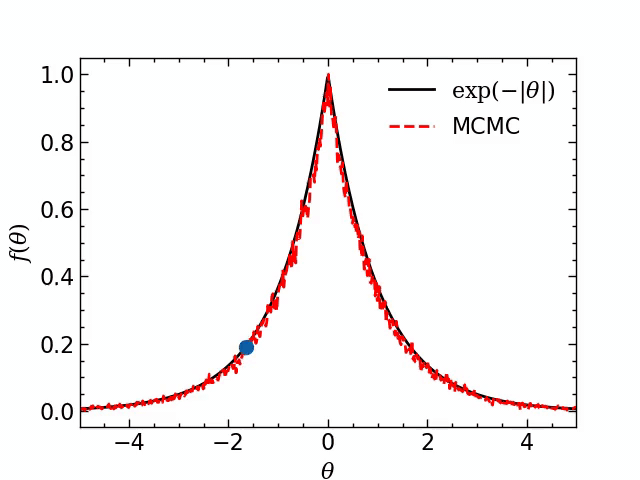

In [155]:
Image("images/mcmc.gif")

In [156]:
# 采样的时候输入参数是 100 0000， 结果只返回了 9 0000 个样本，
# 这是因为使用了 warm up 参数与 thin 参数
# 'warmup' removes 10% data
# 'thin' reduces the size by a fact of 10

print(samples.shape)

(90000, 1)


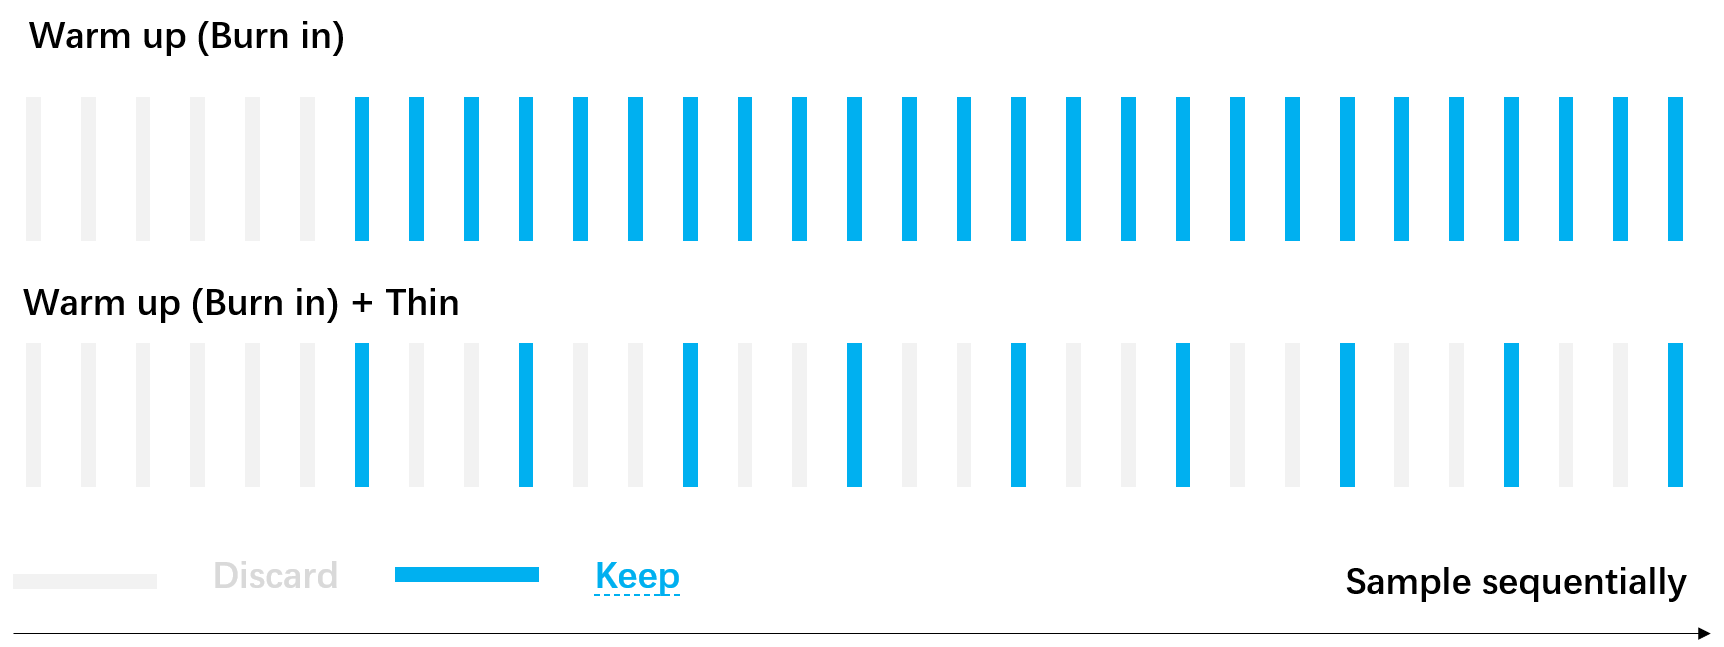

In [157]:
# Warm up 与 thin 这两个参数是什么？  这两个参数都表示要扔掉部分样本。

# warmup=0.1 表示在样本列表的最前端扔掉 10% 的样本，
# thin=10 表示在剩下的样本中每隔 10 个样本保留一个。
# 下图中蓝色是保留下的样本，灰色是扔掉的样本。
Image("images/mcmc_warmup_and_thin.png")

### 为何要扔掉部分采样？

- warm up：如果采样数量有限，初始的某些样本远离平衡分布
- MCMC 抽取的样本不独立，存在时序上的自关联 auto-correlation
- 使用 thin 参数，每隔几个样本保留一个有利于削弱自关联

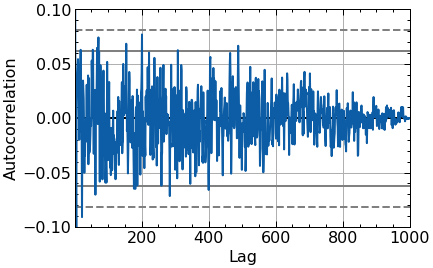

In [158]:
%matplotlib inline
# 先看自关联。 Lag 表示两个样本之间相隔的样本个数，纵坐标表示自关联。
s = pd.Series(samples[:1000].flatten())
ax = pd.plotting.autocorrelation_plot(s)

plt.ylim(-0.1, 0.1)
plt.show()

### Warmup parameter

Warmup （有时候也叫 burn in）是为了扔掉初期还没有达到细致平衡的那些样本。

在二维或高维抽样时可以非常直观看到早期样本不满足最终分布，比如下面这个二维函数

$f(\theta_1, \theta_2) = e^{-|\theta_1|} +  e^{-|\theta_2|}$

In [159]:
def fun2d(theta):
    return np.exp(-np.abs(theta).sum())

fun2d((-0.2, 0.3))

0.6065306597126334

In [160]:
# get 100,000 samples using mcmc
def show_warm_up(nsteps=20):
    ranges_ = np.array([[-8, 8], [-8, 8]])
    samples2d = mcmc(fun2d, ranges_, n=2000, warmup=0.0, step=1)

    plt.scatter(samples2d[:, 0], samples2d[:, 1])
    plt.plot(samples2d[:nsteps, 0], samples2d[:nsteps, 1],
             'ro-', label="initial samples")

    plt.plot(samples2d[0, 0], samples2d[0, 1], 'r*', ms=15, label="start")
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    plt.legend(loc='upper left')

    plt.xlim(-8, 8)
    plt.ylim(-8, 8)

100%|██████████| 2000/2000 [00:00<00:00, 71434.36it/s]


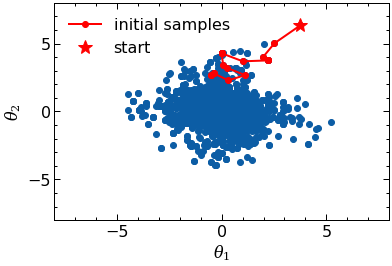

In [161]:
show_warm_up()

100%|██████████| 2000/2000 [00:00<00:00, 83332.75it/s]


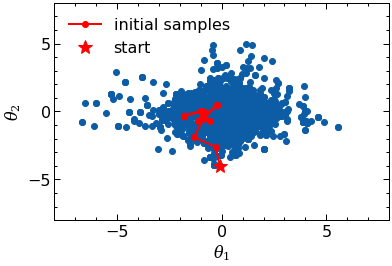

In [162]:
show_warm_up()

100%|██████████| 2000/2000 [00:00<00:00, 83337.72it/s]


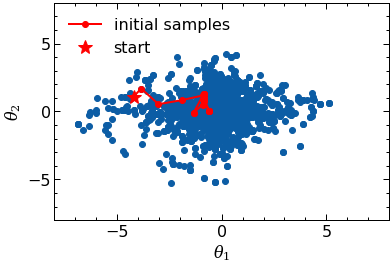

In [163]:
show_warm_up(20)

## 贝叶斯分析中的先验如何影响后验 <a name="prior"></a>

A prior $P(\theta)$ is our belief on the model before doing the experiment.

**先验** （A prior $P(\theta)$）是获得更多数据之前，我们对事件发生可能性的估计

- 问题：先验如何影响后验分布呢？
- 对于任意的先验函数 $P(\theta)$， 后验分布是否会收敛到同一个分布？

接下来我们用扔硬币实验验证。



### 举例：扔硬币实验
这里以扔硬币实验深入介绍先验、似然和后验。
如果一个人投币 10 次，发现 7 次正面朝上，

问：如果投币无数次，正面朝上的概率 $\theta$ 是多少？

频率学派的会说：概率为 $\theta = {k \over n}$ , 其中 k 是 n 次投币中正面朝上的次数。

但只有当投币次数无穷多的情况下可以这样算，只投 10 次，总不能说 $\theta = {7 \over 10}$ 吧？

贝叶斯学派的会说，我们需要算个后验概率， 

$ P(\ \theta\ |\ \rm m \ out \ of\ n ) $

这是一个条件概率，表示 n 次投币观测到 m 次正面向上的情况下， $\theta$ 所满足的分布。
套用实验数据与理论模型语言，此处
- m out of n 表示实验数据
- $\theta$  表示模型参数，待定

根据前一节介绍，只需要一个非归一化的贝叶斯公式，
\begin{align}
P(\ \theta\ |\ \rm m \ out \ of\ n ) \propto P(\ \ \rm m \ out \ of\ n ｜ \theta\ ) P(\theta) 
\end{align}

### 扔硬币实验的先验

上面式子中 $P(\theta)$ 表示先验（a prior)。
先验指一个人根据过去经验，脑海中对某事件发生可能性的概率估计(或信仰 Belief)。

对于一枚硬币，估计大部分人会认为正面向上的概率为 50%， 即 $\theta = 0.5$ 或写成，

\begin{align}
P(\theta) = \delta(\theta - 0.5) 
\end{align}

如果做了10次投币实验，7次正面朝上，部分人可能会完全改变信仰，认为

\begin{align}
P(\theta) = \delta(\theta - 0.7) 
\end{align}

另一部分人可能认为 $\theta$  在 0.5 和 0.7 之间，满足某种分布。

不同的人有不同的先验 $P(\theta)$。

在先验概率未知时，可以用 Beta 分布函数来表示。忽略归一化常数，
\begin{align}
P(\theta) = {\theta^{\alpha-1}(1 - \theta)^{\beta-1} \over B(\alpha, \beta)}
\end{align}

$(\alpha, \beta)$  是 Beta 分布的两个参数，改变这两个参数，Beta 分布会有很多不同的形状。

下面可视化一下 Beta 函数的表示能力，

In [164]:
from scipy.stats import beta    
from ipywidgets import interact

def plot_beta_dist(axis, a=1, b=1):
    '''plot the Beta distribution function
    :a: parameter $\alpha$ in Beta distribution
    :b: parameter $\beta$ in Beta distribution'''
    x = np.linspace(0, 1, 10000)
    y = beta.pdf(x, a, b)
    axis.plot(x, y)
    axis.set_ylabel(r"$P(\theta)$")
    axis.set_xlabel(r"$\theta$")
    axis.set_title(r"$\alpha=%.1f, \beta=%.1f$"%(a, b))

In [165]:
# Let's investigate how does Beta distribution change with alpha and beta
plot = lambda a, b: plot_beta_dist(plt.gca(), a, b)
interact(plot, a=(0, 10.0, 0.1), b=(0, 10.0, 0.1))
# try (a, b) = (1, 1), (0.6, 0.6), (10, 10), (5, 10), (0.1, 10), (10, 0.1)

interactive(children=(FloatSlider(value=5.0, description='a', max=10.0), FloatSlider(value=5.0, description='b…

<function __main__.<lambda>(a, b)>

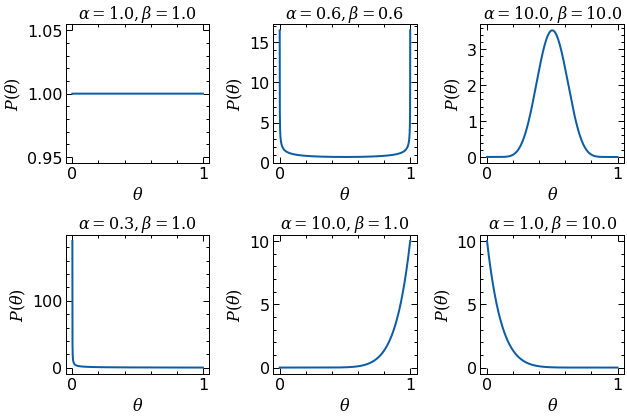

In [166]:
# parameters in 2 rows, 3 columns
params = [[(1, 1), (0.6, 0.6), (10, 10)],
          [(0.3, 1.0), (10, 1), (1, 10)]]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
for i in range(2):
    for j in range(3):
        plot_beta_dist(ax[i][j], *params[i][j])

plt.tight_layout()

上面第一行最左边这张图对应 $(\alpha, \beta) = (1, 1) $, 此时 Beta 分布是均匀分布，即某人相信硬币正面朝上的概率 $\theta = 0, 0.1, 0.2, \cdots, 0.99,\cdots$ 都一样。

第一行中间这张图对应 $(\alpha, \beta) = (0.6, 0.6) $, 此时 Beta 分布是 U 型，表示有另一人相信硬币被做了手脚，要么正面朝上的概率非常大 $\theta \rightarrow 1 $，要么反面朝上的概率非常大， $\theta \rightarrow 0$ 。

第一行右边这张图对应  $(\alpha, \beta) = (10， 10）$ , 此时 Beta 分布是钟型，表示还有人相信硬币没大问题，正面朝上概率为 50% $（ \theta = 0.5 ）$的可能最大，也有其它可能， $P(\theta)$ 非 $\delta$ 函数。

下面一行对应偏到一边的先验。

无论是哪种先验，经过多次实验，随着不确定性的减少，大脑会逐渐调整对这枚硬币正面朝上概率的估计。
后面会调整先验的参数 $(\alpha, \beta) $, 观察先验对后验分布的影响。

扔硬币实验的似然与后验
做 n 次实验有 m 次正面朝上，与正面朝上概率为 $\theta$ 的模型的似然函数为，

\begin{align}
P(\rm m\ out\ of\ n \ |\ \theta) = \left( \begin{array}{c} n \\ m \end{array} \right) \theta^m (1 - \theta)^{n-m}
\end{align}

即二项分布函数 (Binomial distribution)。

二项分布很特殊，一般情况下，我们并不知道模型输出与实验数据的似然函数（likelihood）如何定义。一个比较常用的似然函数是，

\begin{align}
P(y |\ \theta) = \mathcal{K}\exp(- (y-y_{pred})^T \Sigma^{-1} (y-y_{pred}))
\end{align}

其中 $\mathcal{K}$ 是归一化系数，在贝叶斯分析中不重要。

后面的 exp 函数是一个多变量的正态分布函数，方差 $\Sigma^{-1}$ 里保存模型或数据的不确定性。

选择了 Beta 分布函数做先验，知道了似然函数是二项分布，接下来就可以定义扔硬币实验的后验分布，

\begin{align}
P(\theta \ |\rm m\ out\ of\ n ) \propto P(\rm m\ out\ of\ n \ |\ \theta) P(\theta) \propto \theta^{\alpha + m - 1} (1 - \theta)^{\beta+n-m-1}
\end{align}

后验分布同时受到先验分布参数 $(\alpha, \beta)$ 的影响以及测量结果 (m, n) 的影响。

### 先验和观测如何影响参数的后验分布

In [167]:
def plot_posterior(m, n, a, b):
    theta = np.linspace(0.0001, 1, 100, endpoint=False)
    #poster = theta**(a + m - 1) * (1 - theta)**(b + n - m - 1)
    ln_poster = (a +m - 1) * np.log(theta) + (b + n - m - 1) * np.log(1 - theta)
    poster = np.exp(ln_poster)
    prior =  beta.pdf(theta, a, b)
    plt.axvline(m/n, color='k', label='frequency', alpha=0.2)
    plt.plot(theta, poster/poster.max(), label="posterior")
    plt.plot(theta, prior/prior.max(), 'r--', label="prior")
    plt.legend(loc='best')
    plt.xlabel(r"$\theta$")

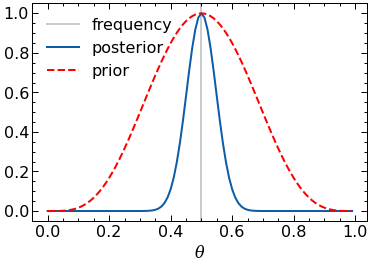

In [168]:
plot_posterior(m=50, n=100, a=5, b=5)
# 第一组，实验110次，55次正面向上。先验 (prior) 是虚线，中心在 0.5，但有很宽的分布，
# 后验 (posterior) 分布是实线，宽度比较窄，表示测量减小了不确定度。频率(frequency)等于 55/110。

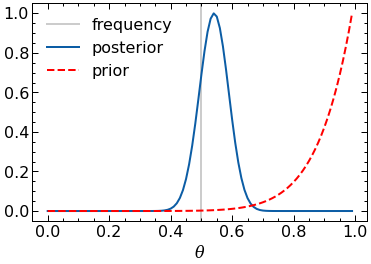

In [169]:
# 第二组，观测数据不变，先验参数为 $\alpha=10, \beta=1 $。
# 先验( Prior ) 偏向右边，而后验分布的中心不在频率(frequency)处，微微偏向先验。
# 如果选 \alpha=1, \beta=10 , 先验和后验都会偏向左边。

plot_posterior(m=50, n=100, a=10, b=1)

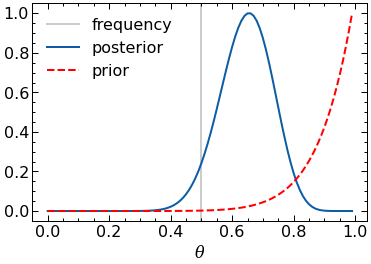

In [170]:
#第三组，观测数据变少，做20次实验，10次正面朝上。先验参数仍为 \alpha=10, \beta=1 ，
# 即初始信仰为正面朝上的概率很大。此时可以看到先验对后验的影响增大。后验向先验靠近更多。

plot_posterior(m=10, n=20, a=10, b=1)

In [171]:
interact(plot_posterior, 
         m=(10, 100), n=(20,200), 
         a = (0, 10.0, 0.2), b = (0, 10.0, 0.2))

interactive(children=(IntSlider(value=55, description='m', min=10), IntSlider(value=110, description='n', max=…

<function __main__.plot_posterior(m, n, a, b)>

总结一下：

1. 后验分布的中心一般在先验和频率之间
2. 测量次数少时，先验对后验的影响比较大
3. 测量次数很多时，先验的影响可忽略不计

## 使用 MCMC 算法从后验分布抽样

接下来，就要对投硬币任务， $\theta$ 满足的后验分布函数进行抽样，找到对于给定的实验观测，最可能的 $\theta$ 的值以及 $\theta$ 的分布。

In [172]:
def draw_posterior(m, n, a, b, nsamples=1000000):
    def poster(theta, m=m, n=n, a=a, b=b):
        return theta**(a +m - 1) * (1-theta)**(b + n - m - 1)
    
    samples = mcmc(poster, np.array([[0.0001, 0.9999]]),
                   n=nsamples, warmup=0.1)

    # compute the distribution of these samples using histogram
    hist, edges = np.histogram(samples.flatten(), bins=500)

    x = 0.5 * (edges[1:] + edges[:-1])
    theta = np.linspace(0.0001, 0.9999, 100)
    y = poster(theta)
    
    plt.plot(theta, y/y.max(), 'k-', label = r"$P(\theta | \rm m\ out\ of\ n)$")
    plt.plot(x, hist/hist.max(), 'r-', label="MCMC")
    

    plt.legend(loc='upper left')
    plt.xlabel(r'$\theta$')
    ax1.set_xlim(x[0], x[-1])
    plt.ylim(-0.2, 1.3)

100%|██████████| 1000000/1000000 [00:12<00:00, 80703.74it/s]


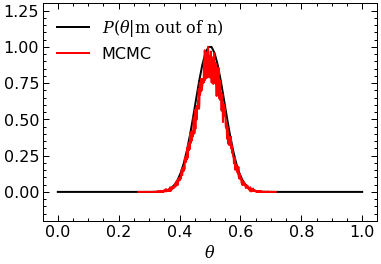

In [173]:
draw_posterior(m=50, n=100, a=5, b=5)

100%|██████████| 1000000/1000000 [00:12<00:00, 82128.78it/s]


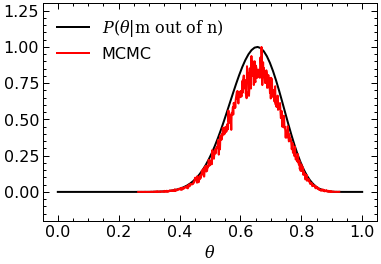

In [174]:
draw_posterior(m=10, n=20, a=10, b=1)

抽样得到了参数 $\theta$ 满足的后验分布，则可以

1. 定义理论模型的不确定度（比如说，90% 置信度）
2. 设定对应置信度下参数的置信区间
3. 寻找最大后验分布对应的模型参数 

## Bayesian analysis for jet energy loss <a name="jeteloss"></a>

In relativistic heavy ion collisions, the jets traverse the hot-dense quark gluon plasma (QGP) and loss transverse momentum $\Delta p_t$.

We want to know the distribution $P(\Delta p_t)$. 

The hard way: 
- construct a hybrid model 
- Use Linear Boltzmann Transport model (LBT) to describe the elastic scattering and gluon radiation in QGP
- Use relativistic hydrodynamics (CLVisc) to describe the space-time evolution of the QGP

The $R_{AA}$ has been widely used to quantify the jet energy loss.

\begin{align}
R_{AA} = {\rm jet\ in\ QGP \over jet\ in\ vaccum} = {\rm jet\ spectra\ in\ heavy\ ion\ collisions \over jet\ spectra\ in\ proton+proton\ collisions}
\end{align}

$R_{AA}$ can be rewritten in a convolution form,

\begin{align}
R_{AA}(p_t) = {\int {dN_{pp} \over dp_t}(p_t + \Delta p_t) W_{AA}(p_t +\Delta p_t \rightarrow p_t) d\Delta p_t \over {dN_{pp} \over dp_t}(p_t)} 
\end{align}

where 
- ${{dN_{pp} \over dp_t}(p_t)}$ is known from experiments or Pythia, 
- $R_{AA}(p_t)$ is the experimental output
- $W_{AA}(p_t +\Delta p_t \rightarrow p_t)$ is the average energy loss distribution (pt shift), modeled using Gamma distribution

## Bayesian analysis steps

- Load and visualize the experimental data
- Define the model, make parameter design
- Define the non-normalized posterior distribution
- Walk in parameter space using MCMC

### Step 1: Load and visualize the experimental data

Text(0, 0.5, '$dN_{pp}/dp_t$')

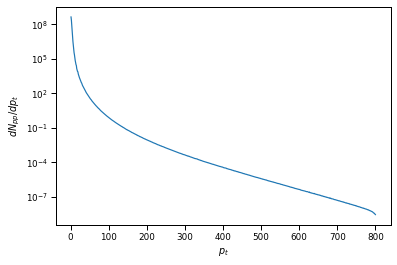

In [13]:
# Load spectra for proton + proton collisions
pp = np.loadtxt(os.path.join("data", "pp2760.csv"))

pp_pt = pp[:, 0]
pp_spec = pp[:, 1]

plt.semilogy(pp_pt, pp_spec)
plt.xlabel(r'$p_t$')
plt.ylabel(r'$dN_{pp}/dp_t$')

Text(0.5, 1.0, 'Pb+Pb 2760 TeV collisions @ LHC')

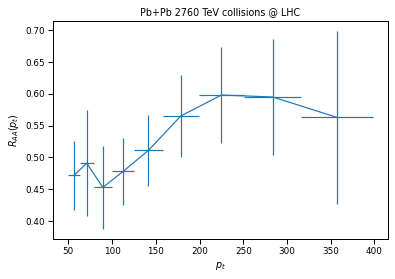

In [14]:
# Load RAA for Pb+Pb 2.76 TeV collisions
raa_data = np.loadtxt(os.path.join("data", "raa2760.csv"))
raa_pt = raa_data[:, 0]
raa_pterr = raa_data[:, 1]
raa_y = raa_data[:, 2]
raa_yerr = raa_data[:, 3]

plt.errorbar(raa_pt, raa_y, yerr=raa_yerr, xerr=raa_pterr)

plt.xlabel(r'$p_t$')
plt.ylabel(r'$R_{AA}(p_t)$')
plt.title("Pb+Pb 2760 TeV collisions @ LHC")

### Step 2: Define the model

In [15]:
import emcee
from scipy.special import gamma
from scipy.special import gammaln
from scipy.integrate import quad
from scipy.interpolate import interp1d

ppfit = interp1d(pp_pt, pp_spec)

@np.vectorize
def gamma_dist(x, alpha, beta):
    ''' gamma distribution whose mean = alpha/beta and var=alpha/beta**2
        :alpha: shape parameter
        :beta: inverse scale parameter
    '''
    #return beta**(alpha) / gamma(alpha) * np.exp(-beta*x) * x**(alpha-1)
    lngamma = alpha * np.log(beta) - gammaln(np.array([alpha]).astype(np.float64)) \
              - beta * x + (alpha-1) * np.log(x)
    return np.exp(lngamma)

@np.vectorize
def raa(pt, alpha, b, c):
    ''' :pt: pt + dpt is the initial jet transverse momentum
        :alpha: the single parameter for Gamma distribution. beta=alpha/<dpt>
        :b, c: parameters used to calc <dpt>, 
    '''
    def intgrand(dpt, pt, alpha, b, c):
        ''':dpt: the pt loss
        :return: dNpp/dpt(pt+dpt) * waa(dpt, pt+dpt)'''
        mean_ptloss = b * (pt+dpt)**c
        beta = alpha/mean_ptloss
        waa = gamma_dist(dpt, alpha, beta)
        return ppfit(pt + dpt) * waa
    
    intg_max = pp_pt[-1] - pt
    # convolution between pp spectra and transition probability
    intg = quad(intgrand, 0, intg_max, args=(pt, alpha, b, c), epsrel=1.0E-4)[0]
    
    return  intg / ppfit(pt)

In [16]:
raa(pt=100, alpha=1, b=1, c=0.5)

array(0.64618742)

### Step 3: Bayesian analysis

- Our original paper uses PYMC to sample from the posterior distribution 
- One can also try other MCMC tools, such as emcee, or your own implementation
- The core is to define posterior distribution of parameters
- **posterior = likelihood * prior** or **log(posterior) = log(likelihood) + log(prior)**

In [17]:
ranges = np.array([[0.1, 10], [0.1, 10], [0.1, 1.0]])

# uniform prior distribution
def prior_pdf(param):
    '''uniform prior distribution if the params (design point)
    locate inside the prior parameter ranges'''
    if (param < ranges[:, 0]).any() or \
       (param > ranges[:, 1]).any():
        return 0
    return 1
            
# likelihood 
def likelihood_pdf(param):
    ''':param: (a, b, c)
    return np.exp(-(y - y_pred)^T \Sigma^{-1} (y - y_pred)).sum()'''
    y = raa_y
    y_pred = raa(raa_pt, param[0], param[1], param[2])
    dy = y - y_pred
    # statistical error contribute to the covariance
    inv_sigma = 1 / (2 * raa_yerr**2)
    return np.exp(- dy * inv_sigma * dy).sum()

# posterior
def posterior_pdf(param):
    return prior_pdf(param) * likelihood_pdf(param)

In [18]:
abc_samples = mcmc(posterior_pdf, ranges, n=10000, thin=1, step=0.2, initial_guess=(2, 2, 0.2))

100%|██████████| 10000/10000 [4:43:21<00:00,  1.70s/it] 


In [19]:
# save the sampled parameters 
df = pd.DataFrame(data=abc_samples, columns=['a', 'b', 'c'])
#df.to_csv("abc_samples.csv")

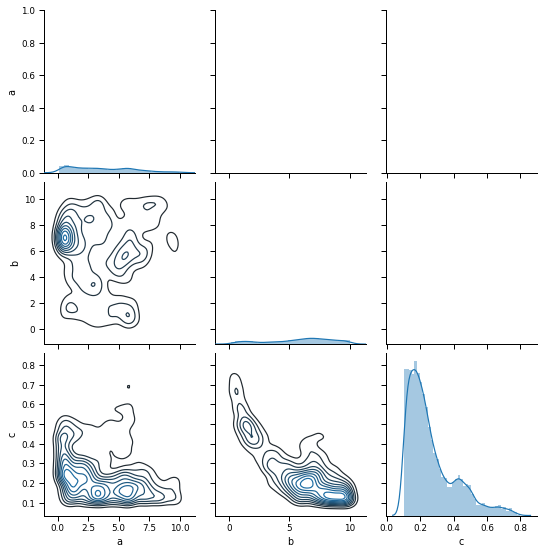

In [68]:
df = pd.read_csv("abc_samples.csv")

# plot the pair correlation
g = sns.PairGrid(df[['a', 'b', 'c']])
g.map_diag(sns.distplot)
g.map_lower(sns.kdeplot)

# in the paper, we used 8 million samples

In [54]:
# plot the raa using sampled params from posterior distribution
def posterior_vs_exp(samples):
    idx = np.random.choice(len(samples), 100)
    for param in samples[idx]:
        a, b, c = param
        y_pred = raa(raa_pt, a, b, c)
        plt.plot(raa_pt, y_pred, 'b-', alpha=0.2)

    plt.errorbar(raa_pt, raa_y, yerr=raa_yerr, xerr=raa_pterr)

    plt.xlabel(r'$p_t$')
    plt.ylabel(r'$R_{AA}(p_t)$')
    plt.title("Pb+Pb 2760 TeV, 0-10% collisions @ LHC")

posterior_vs_exp(abc_samples)

In [56]:
# plot the raa using mean values of sampled params
def posterior_mean_vs_exp(a, b, c):

    a, b, c = a_mean, b_mean, c_mean
    y_pred = raa(raa_pt, a, b, c)
    plt.plot(raa_pt, y_pred, 'r-', alpha=0.5)

    plt.errorbar(raa_pt, raa_y, yerr=raa_yerr, xerr=raa_pterr)

    plt.xlabel(r'$p_t$')
    plt.ylabel(r'$R_{AA}(p_t)$')
    plt.title("Pb+Pb 2760 TeV collisions @ LHC")
    
    plt.text(50, 0.65, "a=%.2f, b=%.2f, c=%.2f"%(a, b, c))

a_mean = np.median(abc_samples[:, 0])
b_mean = np.median(abc_samples[:, 1])
c_mean = np.median(abc_samples[:, 2])
posterior_mean_vs_exp(a_mean, b_mean, c_mean)

## Ways to speed up<a name="emulator"></a>

- Principle Component Analysis
- Gauss Process Emulator
- Latine Super Cube

see https://github.com/keweiyao/BayesExample

###  The numerical integration for each point in parameter space is slow

\begin{align}
R_{AA}(p_t) = {\int {dN_{pp} \over dp_t}(p_t + \Delta p_t) W_{AA}(\Delta p_t, \alpha, b, c ) d\Delta p_t \over {dN_{pp} \over dp_t}(p_t)} 
\end{align}

- Gaussian Process Emulator can speed up model calculation by interpolation in parameter space


100%|██████████| 200/200 [02:55<00:00,  1.14it/s]


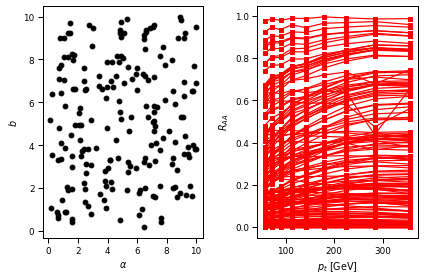

In [24]:
'''First let's randomly pick design points in parameter space,
which will be used for interpolation by Gaussian Process Emulator.'''
def generate_design_points(npoints, ranges, seed=3355):
    ndim = len(ranges)
    np.random.seed(seed)
    r = np.random.rand(npoints, ndim)
    map_range = lambda ri: (1 - ri)*ranges[:, 0] + ri * ranges[:, 1]
    return np.apply_along_axis(map_range, axis=1, arr=r)

# range for a, b, c
ranges = np.array([[0.1, 10], [0.1, 10], [0.1, 1]])

design_points = generate_design_points(200, ranges)

plt.subplot(121)
plt.plot(design_points[:, 0], design_points[:, 1], 'ko')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$b$")

training_data = []

plt.subplot(122)
for a, b, c in tqdm(design_points):
    y = raa(raa_pt, a, b, c)
    training_data.append(y)
    plt.plot(raa_pt, y, 'rs-')
    
training_data = np.array(training_data)

plt.xlabel(r"$p_t$ [GeV]")
plt.ylabel(r"$R_{AA}$")
plt.tight_layout()

# Latin super cube to remove holes in the parameter space

In [25]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def gaussian_process_emulator(design_points, training_data):
    kernel = (
        1. * kernels.RBF(
            length_scale=[1, 1, 1],
            length_scale_bounds=[(.1,10), (.1, 10), (.1, 1)]
        )  
        + kernels.WhiteKernel(.1)
    )
    
    nvalues = len(training_data[0])
    # Build GP for each component in the output (each pt in RAA(pt))
    gps = [GPR(kernel=kernel, n_restarts_optimizer=10) 
            for i in range(nvalues)]

    for i, gp in tqdm(enumerate(gps)):
        gp.fit(design_points, training_data[:,i])
    
    return gps

9it [00:16,  1.84s/it]


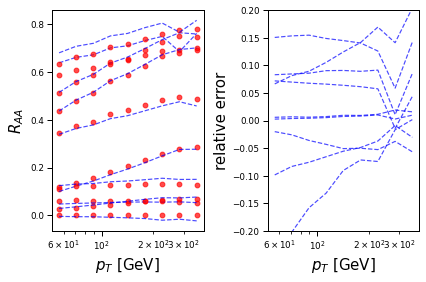

In [26]:
gps = gaussian_process_emulator(design_points, training_data)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
pT = raa_pt
for (a, b, c) in generate_design_points(10, ranges, seed=111):
    # GP prediction
    pred = np.array([gp.predict([(a, b, c)])[0] for gp in gps])
    calc = raa(pT, a, b, c)
    
    ax1.plot(pT, calc, 'ro', alpha=0.7)
    ax1.plot(pT, pred, 'b--', alpha=0.7)
    ax2.plot(pT, (pred-calc)/calc, 'b--', alpha=0.7)

ax1.semilogx()
ax1.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax1.set_ylabel(r'$R_{AA}$', fontsize=15)
ax2.set_ylim(-.2, .2)
ax2.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax2.set_ylabel('relative error', fontsize=15)

plt.tight_layout(True)

In [27]:
def gp_raa(param):
    ''':param: model parameter, in the current case, is (a, b, c)'''
    pred = np.array([gp.predict([param])[0] for gp in gps])
    return pred

gp_raa((1, 2, 3))

array([-7.00286887e-02, -4.86471429e-02, -3.40194332e-02, -1.76687244e-02,
       -9.06373192e-03, -4.72224713e-03, -1.28014630e-03,  3.32206141e-05,
       -3.03073066e-04])

### How to improve the interpolation

- Problem: too many Gaussian Processor Emulators, one for each $p_t$
- Can we compress data to lower dimensions? (E.g., PCA)

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [28]:
npc = 3

pca = PCA(n_components=npc)

# keep the first 3 principle components
h = pca.fit_transform(training_data)

print("before compressing: shape=", training_data.shape)
print("after compressing: shape=", h.shape)

before compressing: shape= (200, 9)
after compressing: shape= (200, 3)


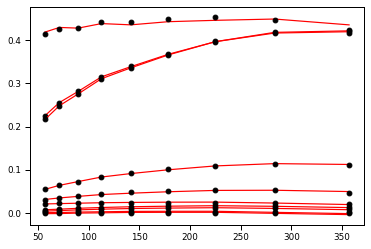

In [29]:
pca_out = pca.inverse_transform(h)

for i in range(10, 20):
    plt.plot(raa_pt, pca_out[i], 'r-')
    plt.plot(raa_pt, training_data[i], 'ko')

In [30]:
# training GP emulator is slow, but predicting with GP is fast
gps_pca = gaussian_process_emulator(design_points, h)

3it [00:05,  1.71s/it]


100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


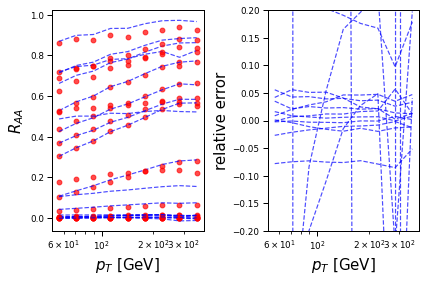

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
pT = raa_pt

testing_design_points = generate_design_points(20, ranges, seed=219)

for (a, b, c) in tqdm(testing_design_points):
    # GP prediction for 3 components from PCA
    pred = np.array([gp.predict([(a, b, c)])[0] for gp in gps_pca])
    # transform back to 9 components experimental data
    pred = pca.inverse_transform(pred)
    
    calc = raa(pT, a, b, c)
    
    ax1.plot(pT, calc, 'ro', alpha=0.7)
    ax1.plot(pT, pred, 'b--', alpha=0.7)
    ax2.plot(pT, (pred-calc)/calc, 'b--', alpha=0.7)

ax1.semilogx()
ax1.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax1.set_ylabel(r'$R_{AA}$', fontsize=15)
ax2.set_ylim(-.2, .2)
ax2.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax2.set_ylabel('relative error', fontsize=15)

plt.tight_layout(True)

# relative error =（pred-calc)/calc, some error is big because calc -> 0

## Summary

- Introduced Bayes analysis and MCMC
- Simple example to extract jet energy loss distribution
- PyMC3 or EMCEE can be used for production
- Latin cube, PCA, Gaussian Process Emulator can be used to speed up

## Backups

### Why do we use $\Gamma$ distribution?

- It is the continous version for "Poisson" distribution
- As one change parameters, $\Gamma$ distribution covers $W(\theta)$ given by hybrid model.
- One limit of $\Gamma$ distribution is the exponential distribution
- The other limit of $\Gamma$ distribution is the normal distribution


### Natural interpretation

- If one out-of-cone energy loss $\Delta p_{t1}$ obeys exponential distribution, 
- the sum of $\alpha$ out-of-cone energy loss $\Delta p_{t1}+\Delta p_{t2} + \cdots + \Delta p_{t\alpha}$ 
obeys $\Gamma$ distribution.

According to central limit theorem,
the total energy loss obey Normal distribution as $\alpha \rightarrow \infty$.

Anyhow, it is a toy model that is used to extract $p_T$ energy loss.

In [ ]:
# this script is to make an animation for the mcmc sampling
%matplotlib notebook
from matplotlib.animation import FuncAnimation
print_to_pdf = False
# compute the distribution of these samples using histogram
hist, edges = np.histogram(samples.flatten(), bins=500)

x = 0.5 * (edges[1:] + edges[:-1])
fig1, ax1 = plt.subplots()

ax1.plot(x, fun(x), 'k-', label = r"$\exp(-|\theta|)$")
ax1.plot(x, hist/hist.max(), 'r--', label="MCMC")

plt.legend(loc='best')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f(\theta)$')
ax1.set_xlim(x[0], x[-1])

dot, = ax1.plot(0, 1, 'o', ms=10)

def update(i):
    xi = samples[i]
    dot.set_data(xi, fun(xi)) 
    return dot,

anim = FuncAnimation(fig1, update, frames=1000, interval=50, blit=False)
#anim.save('images/mcmc.mp4')